<a href="https://colab.research.google.com/github/alexnodejs/bandit/blob/main/HT_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/banana_quality.csv')

df['Quality'] = df['Quality'].map({'Good': 1, 'Bad': 0})

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [4]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.380309,0.626747,0.680712,0.360975,0.567312,0.671933,0.543416,1
1,0.349951,0.628093,0.485275,0.293682,0.481689,0.646850,0.545720,1
2,0.478460,0.699448,0.572694,0.283811,0.499358,0.716580,0.617337,1
3,0.446465,0.705394,0.595677,0.374028,0.473461,0.633590,0.556625,1
4,0.541672,0.687704,0.458841,0.378242,0.442847,0.579430,0.705908,1


Завдання 1

Створіть клас Dataset для тренувальних та тестових даних

In [5]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values)
      self.y = torch.FloatTensor(y.values)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Quality'])
y = df['Quality']

dataset = MyDataset(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42,
                                                    stratify=y)

dataset_train = MyDataset(X_train, y_train)
dataset_test = MyDataset(X_test, y_test)

Перевірка

In [7]:
def check_initialization(X, y):
    try:
        dataset = MyDataset(X, y)
        if torch.is_tensor(dataset.X) and torch.is_tensor(dataset.y):
            print("[OK] Ініціалізація коректна.")
        else:
            print("[FAILED] Ініціалізація не вдалася: X або y не є тензорами.")
    except Exception as e:
        print(f"[FAILED] Помилка ініціалізації: {e}")

def check_y_shape(dataset):
    if dataset.y.ndim == 2 and dataset.y.shape[1] == 1:
        print("[OK] 'y' правильно перетворений на вектор-стовпець.")
    else:
        print(f"[FAILED] 'y' перетворений некоректно, поточна форма: {dataset.y.shape}")

def check_length(dataset, expected_length):
    if len(dataset) == expected_length:
        print("[OK] Перевірка довжини пройдена.")
    else:
        print(f"[FAILED] Перевірка довжини не вдалася. Очікувана довжина: {expected_length}, отримана: {len(dataset)}.")

def check_getitem(dataset, idx):
    try:
        X_item, y_item = dataset[idx]
        if torch.is_tensor(X_item) and torch.is_tensor(y_item):
            print(f"[OK] Отримання елемента коректне для індексу {idx}.")
        else:
            print(f"[FAILED] Отримання елемента некоректне для індексу {idx}.")
    except Exception as e:
        print(f"[FAILED] Помилка у методі `__getitem__`: {e}")

def check_tensor_types(dataset):
    if dataset.X.dtype == torch.float32 and dataset.y.dtype == torch.float32:
        print("[OK] X та y збережені як FloatTensor.")
    else:
        print(f"[FAILED] Невідповідність типу тензорів: X має тип {dataset.X.dtype}, y має тип {dataset.y.dtype}.")


In [ ]:
def main_checks():
    print("\n=== Виконання перевірок ===")
    check_initialization(X, y)
    check_y_shape(dataset_train)
    check_length(dataset_train, len(X_train))
    check_getitem(dataset_train, 0)
    check_tensor_types(dataset_train)
    print("=== Перевірки завершені ===\n")


main_checks()


=== Виконання перевірок ===
[OK] Ініціалізація коректна.
[OK] 'y' правильно перетворений на вектор-стовпець.
[OK] Перевірка довжини пройдена.
[OK] Отримання елемента коректне для індексу 0.
[OK] X та y збережені як FloatTensor.
=== Перевірки завершені ===



**Створіть DataLoader**

In [8]:
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(dataset_train,
                      batch_size=batch_size,
                      shuffle=True,
                      )

test_dl = DataLoader(dataset_test,
                     batch_size=batch_size,
                     shuffle=True,
                     )

In [12]:
def check_batch_size(batch_size):
    if isinstance(batch_size, int) and batch_size > 0:
        print(f"[OK] batch_size встановлений як {batch_size}.")
    else:
        print(f"[FAILED] batch_size некоректний, поточне значення: {batch_size}")

def check_dataloader_initialization(dataset, batch_size):
    try:
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        if isinstance(dataloader, DataLoader):
            print(f"[OK] DataLoader створений коректно з batch_size = {batch_size}.")
        else:
            print("[FAILED] DataLoader не створений.")
    except Exception as e:
        print(f"[FAILED] Помилка під час ініціалізації DataLoader: {e}")

def check_dataloader_loading(dataloader, batch_size):
    try:
        for batch in dataloader:
            print(f"[OK] Форма ознак у батчі: {batch[0].shape}, Форма цільових змінних: {batch[1].shape}")
            if batch[0].shape[0] == batch_size or len(dataloader.dataset) % batch_size != 0:
                print(f"[OK] DataLoader завантажує дані пакетами по {batch_size}.")
            else:
                print(f"[FAILED] Розмір батчу некоректний, очікувано: {batch_size}")
            break
    except Exception as e:
        print(f"[FAILED] Помилка під час завантаження DataLoader: {e}")



In [13]:
def main_checks_dataloader():
    print("\n=== Виконання перевірок DataLoader ===")
    check_batch_size(batch_size)
    check_dataloader_initialization(dataset_train, batch_size)
    check_dataloader_loading(train_dl, batch_size)
    print("=== Перевірки завершені ===\n")

main_checks_dataloader()


=== Виконання перевірок DataLoader ===
[OK] batch_size встановлений як 128.
[OK] DataLoader створений коректно з batch_size = 128.
[OK] Форма ознак у батчі: torch.Size([128, 7]), Форма цільових змінних: torch.Size([128, 1])
[OK] DataLoader завантажує дані пакетами по 128.
=== Перевірки завершені ===



In [14]:
import numpy as np
from torch import nn
import torch.nn.functional as F


class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.linear3 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)

        out = self.linear2(out)
        out = F.relu(out)

        out = self.linear3(out)
        out = F.sigmoid(out)
        return out

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
          y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(7, 100, 1).to(device)
model

BinaryClassifier(
  (linear1): Linear(in_features=7, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

In [15]:
def check_last_activation(model):
    # Використовуємо фіктивний вхід для перевірки виходу останнього шару
    input_dim = model.linear1.in_features
    test_input = torch.randn(100, input_dim)

    try:
        # Пропускаємо через forward, щоб перевірити останню функцію активації
        output = model.forward(test_input)

        if isinstance(output, torch.Tensor):
            # Перевіряємо, чи відповідає вихід сигмоїді (діапазон значень між 0 і 1)
            if torch.all(output >= 0) and torch.all(output <= 1):
                print("[OK] Остання функція активації - sigmoid")
            else:
                print("[FAILED] Остання функція активації не sigmoid, вихід: ", output)
        else:
            print("[FAILED] Невірний вихід, очікувався тензор")
    except Exception as e:
        print(f"[FAILED] Помилка під час перевірки функції активації sigmoid: {e}")

# Перевірка функції forward
def check_forward(model, input_shape):
    try:
        input_tensor = torch.randn(input_shape)
        output = model.forward(input_tensor)

        if output.shape[1] == 1:
            print(f"[OK] Функція forward працює, вихід: {output.shape}")
        else:
            print(f"[FAILED] Невірний вихід функції forward, вихід: {output.shape}")
    except Exception as e:
        print(f"[FAILED] Помилка у функції forward: {e}")

# Перевірка функції predict
def check_predict(model, X_sample):
    try:
        device = 'cpu'  # Можна змінити на GPU, якщо потрібно
        output = model.predict(X_sample, device=device)

        if isinstance(output, np.ndarray):
            print("[OK] Функція predict працює, вихід - NumPy масив")
        else:
            print("[FAILED] Невірний тип виходу функції predict, очікується NumPy масив")
    except Exception as e:
        print(f"[FAILED] Помилка у функції predict: {e}")

In [16]:
# Основна функція для виклику перевірок
def main_check(model, input_shape, X_sample):
    print("Розпочинаю перевірку моделі...")
    check_last_activation(model)
    check_forward(model, input_shape)
    check_predict(model, X_sample)


main_check(model, X_train.shape, X_train)

Розпочинаю перевірку моделі...
[OK] Остання функція активації - sigmoid
[OK] Функція forward працює, вихід: torch.Size([6400, 1])
[OK] Функція predict працює, вихід - NumPy масив


In [17]:
#Визначте функцію втрат та оптимізатор

In [18]:
from torchsummary import summary

summary(model, input_size=(7,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             800
            Linear-2                   [-1, 50]           5,050
            Linear-3                    [-1, 1]              51
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [19]:
# Функція втрат середньоквадратичної помилки (MSE) для регресії
loss_fn = nn.BCELoss()

# Оптимізатор (SGD) для оновлення ваг моделі
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

**Натренуйте нейромережу. Візміть невелику кількість епох**

In [20]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [29]:
from sklearn.metrics import accuracy_score, recall_score

history = train(model, optimizer, loss_fn, train_dl, test_dl,
                epochs=25,
                metrics=[accuracy_score, recall_score],
                device=device,
                task='binary')

train() called: model=BinaryClassifier, opt=SGD(lr=0.010000), epochs=25, device=cpu

Epoch    1    1sec	loss:      0.623	val_loss:      0.619	accuracy_score:      0.814	val_accuracy_score:      0.811	recall_score:      0.962	val_recall_score:      0.979	
Epoch    2    1sec	loss:      0.618	val_loss:      0.614	accuracy_score:       0.82	val_accuracy_score:      0.812	recall_score:      0.962	val_recall_score:      0.985	
Epoch    3    1sec	loss:      0.613	val_loss:      0.609	accuracy_score:      0.818	val_accuracy_score:      0.816	recall_score:      0.962	val_recall_score:      0.975	
Epoch    4    1sec	loss:      0.607	val_loss:      0.603	accuracy_score:      0.817	val_accuracy_score:      0.824	recall_score:      0.958	val_recall_score:      0.963	
Epoch    5    0sec	loss:      0.601	val_loss:      0.596	accuracy_score:      0.821	val_accuracy_score:      0.824	recall_score:      0.954	val_recall_score:      0.947	
Epoch    6    0sec	loss:      0.595	val_loss:       0.59	accuracy

**Виведіть графіки метрик та марицю помилок**

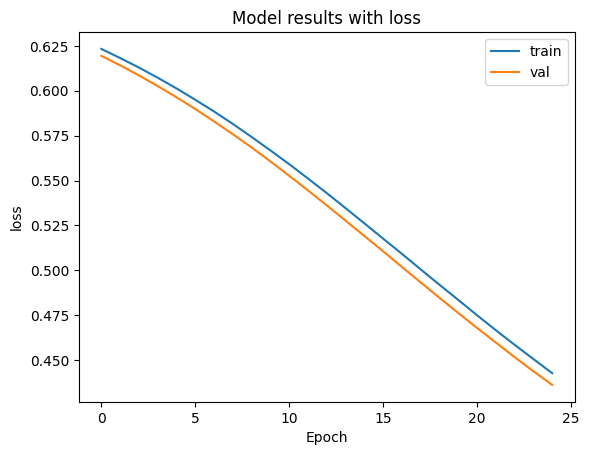

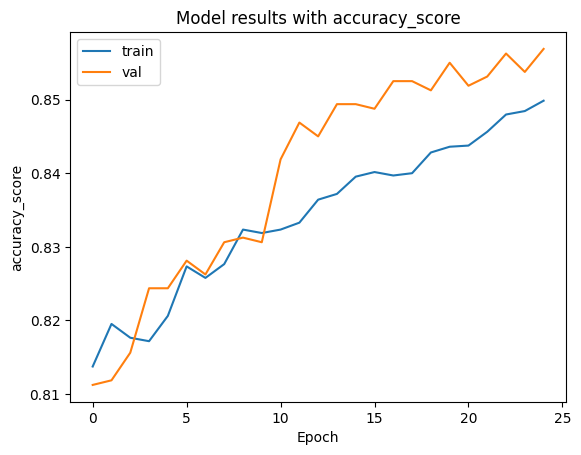

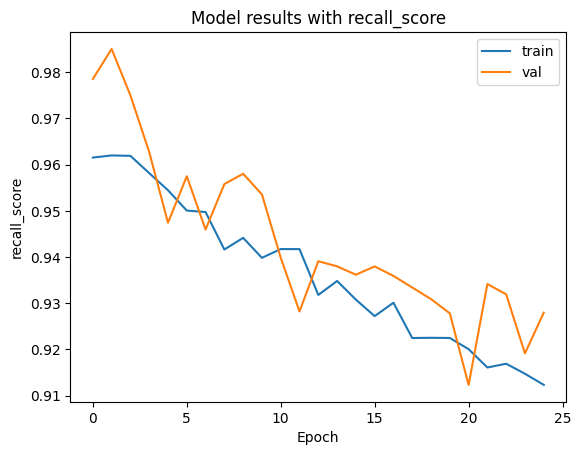

In [30]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()

plot_metric(history, 'loss')
plt.show()

plot_metric(history, 'accuracy_score')
plt.show()

plot_metric(history, 'recall_score')
plt.show()

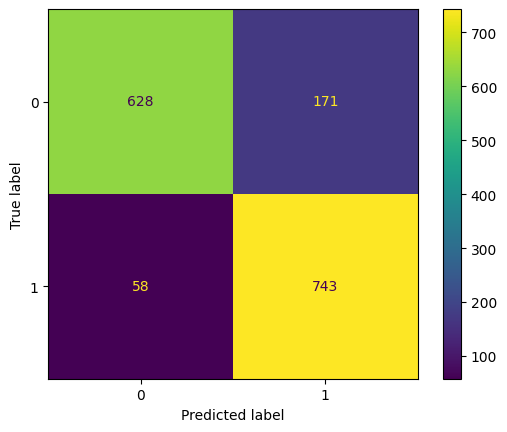

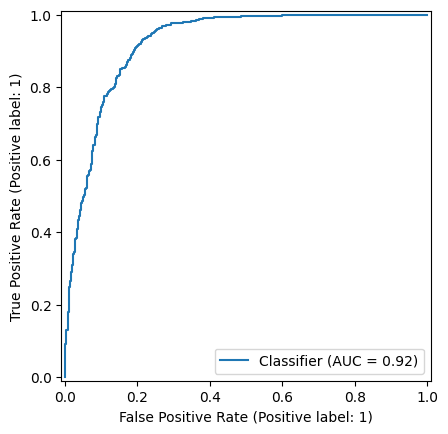

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')  # відключаємо від gpu
y_pred = model.predict(X_test, device)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round())
plt.plot()

RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)

In [32]:
from sklearn.metrics import classification_report # 25 epochs

report = classification_report(y_true=y_test, y_pred=y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       799
           1       0.81      0.93      0.87       801

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600



In [28]:
# from sklearn.metrics import classification_report - 15 epochs - looks better

# report = classification_report(y_true=y_test, y_pred=y_pred.round())
# print(report)

              precision    recall  f1-score   support

           0       0.96      0.65      0.78       799
           1       0.74      0.98      0.84       801

    accuracy                           0.81      1600
   macro avg       0.85      0.81      0.81      1600
weighted avg       0.85      0.81      0.81      1600

